# Introduction

Clustering is a very hard problem because there is never truly 'right' answer when labels are unknown.

To complicate matters further there is **[No Free Lunch](https://en.wikipedia.org/wiki/No_free_lunch_in_search_and_optimization)** for clustering algorithms and while one algorithm might fit a certain dataset well, there are no guarantees that it will work on a different data the exact same way. 
Likewise, clustering is *"strongly dependent on contexts, aims and decisions of the researcher"* which adds fire to the argument that there is no such thing as a *"universally optimal method that will just produce natural clusters"* ( see [What Are True Clusters? Henning 2015](https://arxiv.org/abs/1502.02555) ).

Moreover, clustering techniques that generalize well, such as KMeans, assume that data is numerical and sphere-shaped. Having data of mixed types with high dimensionality also presents challenges for the downstream clustering task as classical methods such as Principal Component Analysis PCA for dimensionality reduction do not work when categorical values are included. This leads to a conundrum for the practitioner where specific featurization schemes must be formalized - such as including only numerical values or transforming all to categorical and then using Multiple Correspondence Analysis MCA instead.

The approach outlined here seeks to solve both the difficulty in finding a default clustering algorithm and to circumvent the difficulties represented when data is in a mixed type form. Using a combination of the [Uniform Manifold Approximation and Projection UMAP](https://arxiv.org/abs/1802.03426) and [Hierarchical Density Based Clustering HDBSCAN](https://arxiv.org/abs/1705.07321) we will first take mix type data and then map it into a dense lower dimensional space. From this dense space, we will then hierarchically group into clusters based on the density of points. The final result will provide a simple end to end to solution that can be applied on wide variety of data to find meaningful clusters.


In [1]:
%pip install matplotlib seaborn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics, preprocessing

from denseclus import DenseClus

%matplotlib inline


warnings.filterwarnings("ignore")

/Users/frenzcha/Documents/amazon-denseclus/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={"figure.figsize": (10, 8)})

In [4]:
SEED = 42
np.random.seed(SEED)  # set the random seed as best we can

data_url = (
    "https://raw.githubusercontent.com/awslabs/aws-customer-churn-pipeline/main/data/churn.txt"
)
df = pd.read_csv(data_url).sample(n=2000, random_state=SEED)

In this example, you will use a synthetic churn dataset for an imaginary telecommunications company with the outcome Churn? flagged as as either True (churned) or False (did not churn). Features include customer details such as plan and usage information. The churn dataset is publicly available and mentioned in the book [Discovering Knowledge in Data by Daniel T. Larose](https://www.amazon.com/dp/0470908742/). It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.

In [5]:
df.drop(["Phone", "Area Code"], axis=1, inplace=True)
df.dtypes

State              object
Account Length      int64
Int'l Plan         object
VMail Plan         object
VMail Message       int64
Day Mins          float64
Day Calls           int64
Day Charge        float64
Eve Mins          float64
Eve Calls           int64
Eve Charge        float64
Night Mins        float64
Night Calls         int64
Night Charge      float64
Intl Mins         float64
Intl Calls          int64
Intl Charge       float64
CustServ Calls      int64
Churn?             object
dtype: object

As you can see the data consists of both categorical and numeric features.
Generally, speaking this is problematic for traditional dimension reduction and clustering methods such as [K-Means](https://en.wikipedia.org/wiki/K-means_clustering) as they rely input features to be numeric and assume that the values are shaped spherical in nature.

With DenseClus this is not an issue because we use create UMAP embeddings for both categorical and numerical, combining the embedding space to output them into the densest space possible. Next HDBSCAN is run to group densities into clusters, resulting a groups of mixed-type data. 

All of this is done under the hood and just requires a `fit` call like below.

In [6]:
hdbscan_params = {"cluster_selection_method": "leaf"}

clf = DenseClus(
    random_state=SEED,
    umap_combine_method="intersection_union_mapper",
    hdbscan_params=hdbscan_params
)

clf.fit(df)

Max of 51 is greater than threshold 25
Hashing categorical features


As a recap the steps that happened are:

1). Numerical features were taken out and then reduced into a *dense* UMAP embedding

2) Categorical features got extracted and learned into a *dense* separate UMAP embedding

3) The two embeddings were then combined with an intersection over union operation

4) HDBSCAN uses density-based spatial clustering to hierarchical-fashion to extract clusters from the combined space

All of these features are now attached as usable `DenseClus` object. 

## Checking Embedding Results

Verify the embeddings are now densely shaped.

In [7]:
for i in range(clf.n_components):
    sns.kdeplot(clf.mapper_.embedding_[:, i], shade=True)

AttributeError: 'DenseClus' object has no attribute 'n_components'

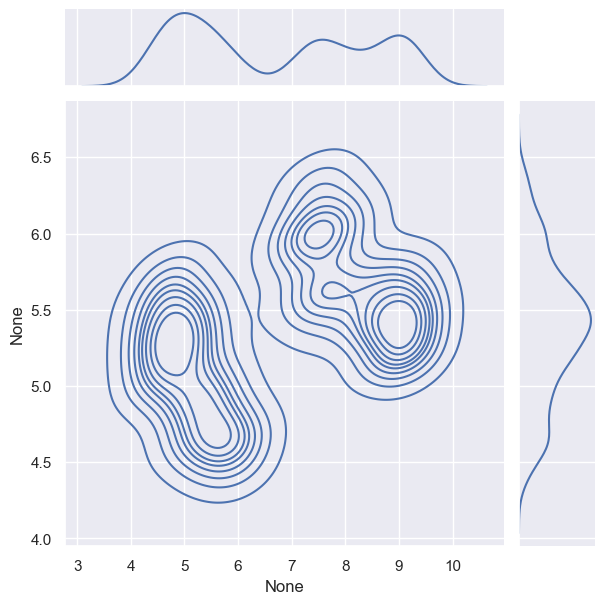

In [ ]:
_ = sns.jointplot(x=clf.mapper_.embedding_[:, 0], y=clf.mapper_.embedding_[:, -1], kind="kde")

# Inspection of Cluster Results

The clustering results are extricable from the object.

X groups formed into clusters, with the largest constituting Y% of the data.

In [ ]:
labels = clf.score()

print(labels, "\n")
print(pd.DataFrame(labels).value_counts(normalize=True))

[0 2 2 ... 0 2 2] 

 3    0.2355
 0    0.2340
 2    0.2330
 1    0.2325
-1    0.0650
Name: proportion, dtype: float64


Just like with DBSCAN, labels of -1 are flagged as noise and all lables have an associated noise probability score.

In practice, these can be thrown out or put into an 'other' cluster.

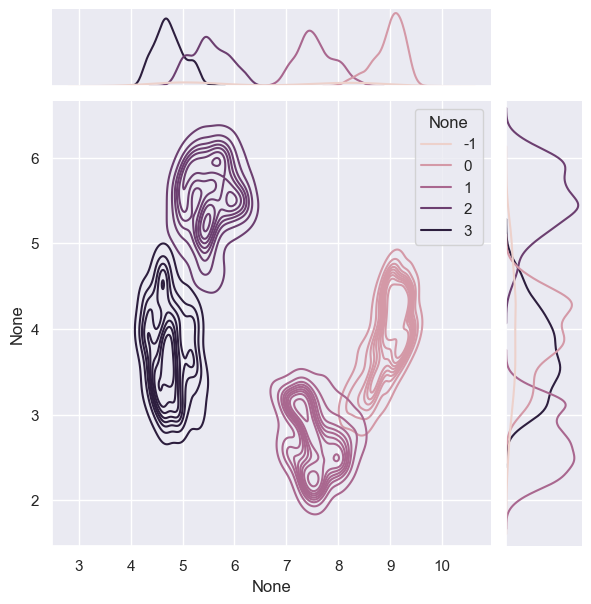

In [ ]:
_ = sns.jointplot(
    x=clf.mapper_.embedding_[:, 0],
    y=clf.mapper_.embedding_[:, 1],
    hue=labels,
    kind="kde",
)

As you can see above, the clusters formed based on the densities represented in the reduced space.

Specifically, 4 groups got identified by the data.

Since HDBSCAN is hierarchical in nature and splits based on a tree.

Instead of using the default method, you used `leaf` which splits into smaller groups along the tree. 

The below plot shows that the default setting would find two clusters total but since we split along the leaf there are four.

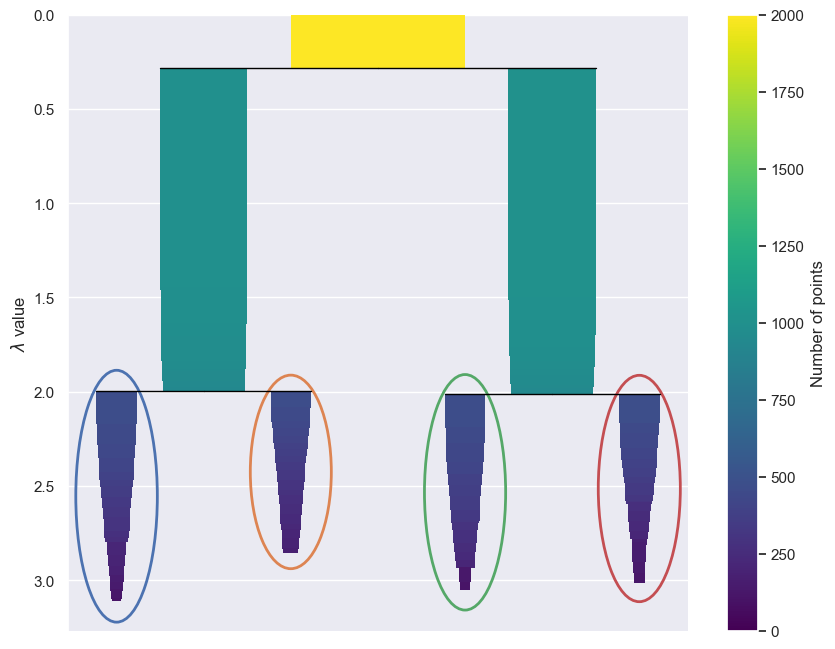

In [ ]:
_ = clf.hdbscan_.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette("deep", np.unique(labels).shape[0]),
)

# Profiling the Clusters

Finally, once clusters are formed, it's common practice to then describe what each one means.

Here, descriptive statistics is actually a very powerful (and efficient) tool to use.

In [ ]:
df["segment"] = clf.score()

numerics = df.select_dtypes(include=[int, float]).drop(labels=['segment'], axis=1).columns.tolist()

df[numerics + ["segment"]].groupby(["segment"]).median()

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
segment,,,,,,,,,,,,,,,
-1,99.5,0.0,5.217604,3.0,5.390701,5.411209,3.0,4.912976,3.921860,250.0,5.668275,5.106088,5.0,3.651251,6.0
0,107.5,500.0,2.733090,3.0,3.942918,4.005048,4.0,3.678772,4.146281,300.0,3.993230,5.001423,5.0,4.226862,5.0
1,95.0,300.0,7.216213,4.0,5.954501,5.817991,2.0,5.947489,3.916038,150.0,6.135542,5.083313,5.0,4.533116,5.0
2,107.0,0.0,2.958452,3.0,4.080853,3.985954,4.0,3.881036,3.982285,300.0,3.879150,5.020249,5.0,3.964109,5.0
3,99.0,0.0,7.685395,4.0,6.262598,6.139366,2.0,6.201804,3.805200,150.0,6.201740,5.070900,5.0,4.644275,6.0


Let's ignore group `-1`.

You can see that only first segment `0` has the shortest day minutes and high night calls. These are perhaps customers that prefer calling (and getting called) in the night.

The second segment `1` has the highest day minutes and day charges. These are customer that prefer calling (and getting called) during the day.

This type of profiling is possible with the other segments as well, coming up with a description of what attributes they constitute and how they relate to your objective.

Again, this is just profiling but descriptive statistics are revealing of what patterns are captured.

A similar type of analysis is possible with categorical features, with a reference shown below.

In [ ]:
categorical = df.select_dtypes(include=["object"]).drop(labels=["State"], axis=1)

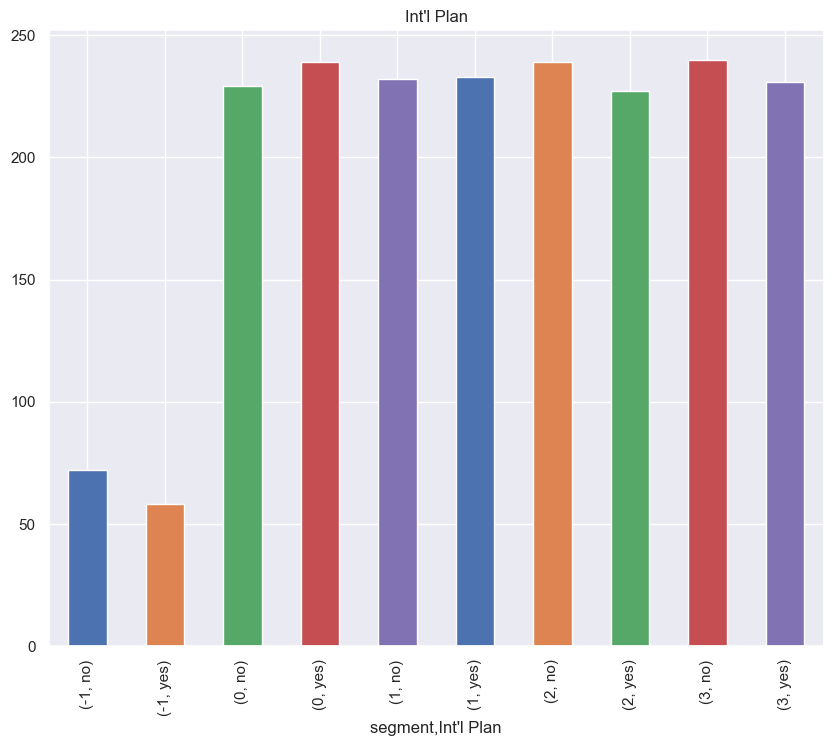

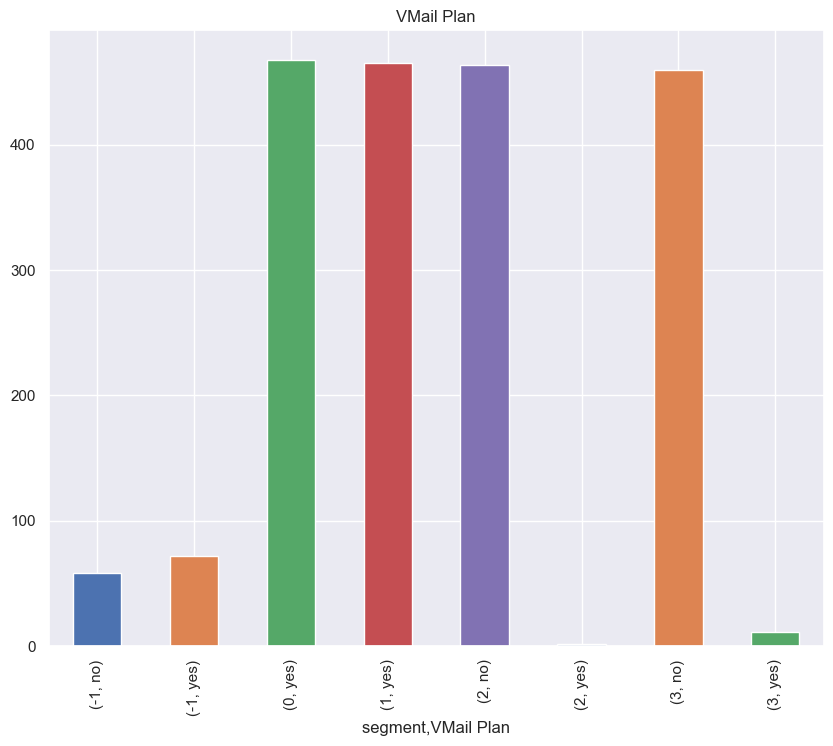

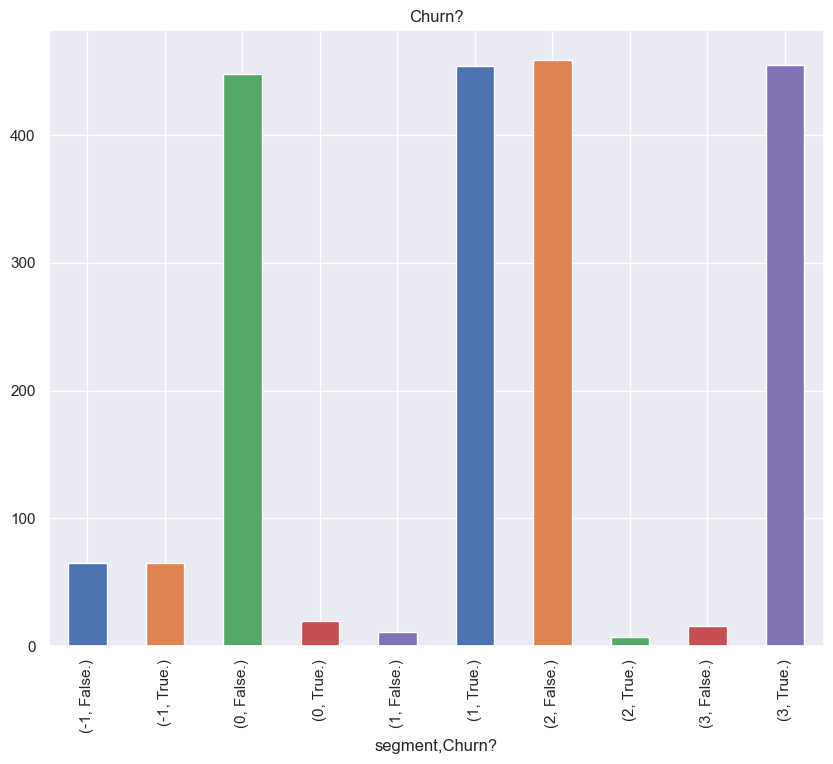

In [ ]:
for c in categorical.columns:
    df.groupby(["segment"] + [c]).size().plot(
        kind="bar", color=sns.color_palette("deep", np.unique(labels).shape[0])
    )
    plt.title(c)
    plt.show()